In [26]:
import os 

import pandas as pd
import numpy as np
import tqdm

import matplotlib.pyplot as plt
from models import get_models
from preprocessing import general_preprocessing, view_direction_preprocessing



In [27]:
df = pd.read_csv(r"C:\Felix\weather_dataset\Student Labeled\student_labelled.csv")
df["Weather"] = df.Weather.replace({"snowfall":"Snowy","rainfall":"Rainy","clear":"Clear","cloudy":"Cloudy"})
df.loc[df.Cover == "snow","Weather"] = "Snowy"
df.loc[df.Cover == "rain","Weather"] = "Rainy"
df = df.loc[(df.Weather != 'unobservable') & (df.Lighting_Condition == "day")] 
df.value_counts("Weather")

df["path"] = [os.path.join(r"C:\Felix\weather_dataset\Student Labeled\images_renamed",str(i))+".jpeg" for i in df.id]
df = df.loc[df.path.apply(os.path.exists)]
df["origin"] = "Student_samples"

In [28]:
paths = [
    (r"C:\Felix\weather_dataset\SSLAD-2D\Clear",'Clear',"SSLAD-2D"),
    (r"C:\Felix\weather_dataset\SSLAD-2D\Overcast",'Cloudy',"SSLAD-2D"),
    (r"C:\Felix\weather_dataset\SSLAD-2D\Rainy",'Rainy',"SSLAD-2D"),
    (r"C:\Felix\weather_dataset\Raidar\test","Rainy","Raidar"),
    (r"C:\Felix\weather_dataset\Raidar\train","Rainy","Raidar"),
    (r"C:\Felix\weather_dataset\mapilar snow\images","Snowy","Yujun-Mapilarly"),
    (r"C:\Felix\weather_dataset\Foggy Cityscapes","Foggy","Foggy Cityscapes"),
    (r"C:\Felix\weather_dataset\Duckduckgo\fog","Foggy","Duckduckgo"),
    (r"C:\Felix\weather_dataset\Duckduckgo\snow","Snowy","Duckduckgo"),
    (r"C:\Felix\weather_dataset\DAWN\Rain","Rainy","Dawn"),
    (r"C:\Felix\weather_dataset\DAWN\Snow","Snowy","Dawn"),
    (r"C:\Felix\weather_dataset\DAWN\Fog","Foggy","Dawn"),
]

erg = []

for folder, weather, origin in paths:

    for img in os.listdir(folder):
        if ".jpg" in img or ".jpeg" in img:
            erg.append((os.path.join(folder,img),weather,origin))   

new = pd.DataFrame(erg,columns=["path","weather","origin"])
df = pd.concat([df[["path","Weather","origin"]].rename(columns={"Weather":"weather"}),new])
df.index = range(len(df))

In [29]:
# ds = general_preprocessing.get_ds(df,64)

# model = get_models.get_pano()
# preds = model.predict(ds,verbose=1) > .5

In [30]:
# tf.keras.backend.clear_session()
# model = get_models.get_night_day()
# night_preds = model.predict(ds,verbose=1) > .5
# np.save("../weather_dataset/night_pred.npy",night_preds)
# np.save("../weather_dataset/pano_pred.npy",preds)

In [31]:
# out = r"C:\Felix\weather_dataset\night"
# import tqdm
# night = df.loc[night_preds]
# for i in tqdm.tqdm(range(len(night))):
#     row = night.iloc[i]
#     img = plt.imread(row.loc["path"])
#     plt.imshow(img)
#     plt.savefig(os.path.join(out,f"{i}_{row['origin']}")+".jpg")
#     plt.close()

In [32]:
night_preds = np.load("../weather_dataset/night_pred.npy")
pano_preds = np.load("../weather_dataset/pano_pred.npy")
df = df.loc[(~pano_preds) & (~night_preds)]

In [33]:
paths = [os.path.join(r'C:\Felix\weather_dataset\clear',i) for i in os.listdir(r'C:\Felix\weather_dataset\clear')]
df.index = range(len(df))
origin = ["Student_samples" for i in range(len(paths))]
weather = ["Clear" for i in range(len(paths))]
vals = list(zip(paths,weather,origin))
df= pd.concat([df,pd.DataFrame(vals,columns=["path","weather","origin"])])
df.index = range(len(df))

In [34]:
df.value_counts(["origin","weather"])

origin            weather
Raidar            Rainy      18212
SSLAD-2D          Clear       9402
Student_samples   Clear       5224
SSLAD-2D          Cloudy      4453
                  Rainy       2107
Yujun-Mapilarly   Snowy       1963
Duckduckgo        Snowy       1080
                  Foggy       1008
Dawn              Foggy        294
Student_samples   Cloudy       264
Dawn              Snowy        203
                  Rainy        195
Foggy Cityscapes  Foggy        101
Student_samples   Snowy         29
                  Rainy         10
dtype: int64

In [35]:
df["ds_type"] = "train"
df.loc[df.origin=="Student_samples","ds_type"] = "test"
test = df.loc[(df.origin == "Dawn" )& (df.weather=="Foggy")].sample(n=60,random_state=0).index.tolist()
foggy_city = ( df.loc[(df.origin == "Foggy Cityscapes" )].sample(frac=1,random_state=0).index.tolist())



test.extend( df.loc[(df.origin == "Dawn" )& (df.weather=="Snowy")].sample(n=150,random_state=0).index.tolist())
test.extend( df.loc[(df.origin == "Duckduckgo" )& (df.weather=="Snowy")].sample(n=150,random_state=0).index.tolist())
test.extend( df.loc[(df.origin == "Dawn" )& (df.weather=="Rainy")].index.tolist())
test.extend( df.loc[(df.origin == "SSLAD-2D" )& (df.weather=="Rainy")].sample(n=150,random_state=0).index.tolist())
clear_student= ( df.loc[(df.origin == "Student_samples" )& (df.weather=="Clear")].sample(n=5200-520,random_state=0).index.tolist())
val = df.loc[(df.origin == "Raidar") &(df.path.str.contains("test"))].sample(n=300,random_state=0).index.tolist()
train = clear_student[:-520]

test.extend(foggy_city[:len(foggy_city)//2])
val.extend(foggy_city[len(foggy_city)//2:])
val.extend(clear_student[-520:])

df.loc[test,"ds_type"] = 'test'
df.loc[train,"ds_type"] = 'train'

rest = df.loc[df.ds_type=="train"]
val.extend(rest.loc[(rest.origin == "Duckduckgo" )& (rest.weather=="Foggy")].sample(n=60,random_state=0).index.tolist())

val.extend(rest.loc[(rest.origin == "Duckduckgo" )& (rest.weather=="Snowy")].sample(n=150,random_state=0).index.tolist())
val.extend(rest.loc[(rest.origin == "Yujun-Mapilarly" )& (rest.weather=="Snowy")].sample(n=150,random_state=0).index.tolist())

val_raidar_to_trop =[i for i in rest.loc[(rest.origin == "Raidar") &(rest.path.str.contains("test"))].index if i not in val]
df.loc[val_raidar_to_trop[:150],"ds_type"] = "test"

df.loc[val,"ds_type"] = 'val'
val_raidar_to_trop.extend(df.query("ds_type == 'train' & weather=='Rainy'").sample(n=12000,random_state=0).index.tolist())
df = df.drop(index= val_raidar_to_trop[150:])

to_val = (df.loc[(df.origin == "Student_samples" )& (df.weather=="Cloudy")].sample(n=100,random_state=0).index.tolist())
df.loc[to_val,"ds_type"]="val"

cloudy_to_spread = (df.loc[(df.origin == "SSLAD-2D" )& (df.weather=="Cloudy")].sample(n=300,random_state=0).index.tolist())
df.loc[cloudy_to_spread[:150],"ds_type"]="val"
df.loc[cloudy_to_spread[150:],"ds_type"]="test"

trop_clear = df.loc[(df.ds_type=="train") & (df.weather=="Clear") & (df.origin !="Student_samples")].index.tolist()
df = df.drop(index= trop_clear)

train_raidar = df.loc[(df.ds_type=="train")  & (df.origin =="Raidar")].sample(n=2000,random_state=0).index.tolist()
df = df.drop(index= train_raidar)

to_val = df.loc[(df.weather=="Rainy")  & (df.origin =="Dawn")].sample(n=90,random_state=0).index.tolist()
df.loc[to_val,"ds_type"] = 'val'

df.sort_values(["ds_type","weather","origin"])

,path,weather,origin,ds_type
0,C:\Felix\weather_dataset\Student Labeled\image...,Clear,Student_samples,test
21,C:\Felix\weather_dataset\Student Labeled\image...,Clear,Student_samples,test
24,C:\Felix\weather_dataset\Student Labeled\image...,Clear,Student_samples,test
25,C:\Felix\weather_dataset\Student Labeled\image...,Clear,Student_samples,test
63,C:\Felix\weather_dataset\Student Labeled\image...,Clear,Student_samples,test
...,...,...,...,...
37335,C:\Felix\weather_dataset\mapilar snow\images\9...,Snowy,Yujun-Mapilarly,val
37338,C:\Felix\weather_dataset\mapilar snow\images\9...,Snowy,Yujun-Mapilarly,val
37344,C:\Felix\weather_dataset\mapilar snow\images\9...,Snowy,Yujun-Mapilarly,val
37347,C:\Felix\weather_dataset\mapilar snow\images\9...,Snowy,Yujun-Mapilarly,val


In [36]:
df.query("ds_type == 'val'").value_counts(["weather","origin"])

weather  origin          
Clear    Student_samples     520
Rainy    Raidar              300
Cloudy   SSLAD-2D            150
Snowy    Duckduckgo          150
         Yujun-Mapilarly     150
Cloudy   Student_samples     100
Rainy    Dawn                 90
Foggy    Duckduckgo           60
         Foggy Cityscapes     51
dtype: int64

In [37]:
df.query("ds_type == 'test'").value_counts(["weather","origin"])


weather  origin          
Clear    Student_samples     544
Cloudy   Student_samples     164
         SSLAD-2D            150
Rainy    Raidar              150
         SSLAD-2D            150
Snowy    Dawn                150
         Duckduckgo          150
Rainy    Dawn                105
Foggy    Dawn                 60
         Foggy Cityscapes     50
Snowy    Student_samples      29
Rainy    Student_samples      10
dtype: int64

In [38]:
df.query("ds_type == 'train'").value_counts(["weather","origin"])

weather  origin         
Clear    Student_samples    4160
Cloudy   SSLAD-2D           4153
Rainy    Raidar             3644
Snowy    Yujun-Mapilarly    1813
Foggy    Duckduckgo          948
Rainy    SSLAD-2D            782
Snowy    Duckduckgo          780
Foggy    Dawn                234
Snowy    Dawn                 53
dtype: int64

In [39]:
df.query("ds_type == 'train'").value_counts(["weather"])

weather
Rainy      4426
Clear      4160
Cloudy     4153
Snowy      2646
Foggy      1182
dtype: int64

In [40]:
df.query("ds_type == 'train'").value_counts(["weather"],normalize=True)


weather
Rainy      0.267158
Clear      0.251102
Cloudy     0.250679
Snowy      0.159715
Foggy      0.071347
dtype: float64

In [41]:
df.query("ds_type == 'val'").value_counts(["weather"],normalize=True)


weather
Clear      0.330999
Rainy      0.248250
Snowy      0.190961
Cloudy     0.159134
Foggy      0.070656
dtype: float64

In [42]:
df.query("ds_type == 'test'").value_counts(["weather"],normalize=True)

weather
Clear      0.317757
Rainy      0.242407
Snowy      0.192173
Cloudy     0.183411
Foggy      0.064252
dtype: float64

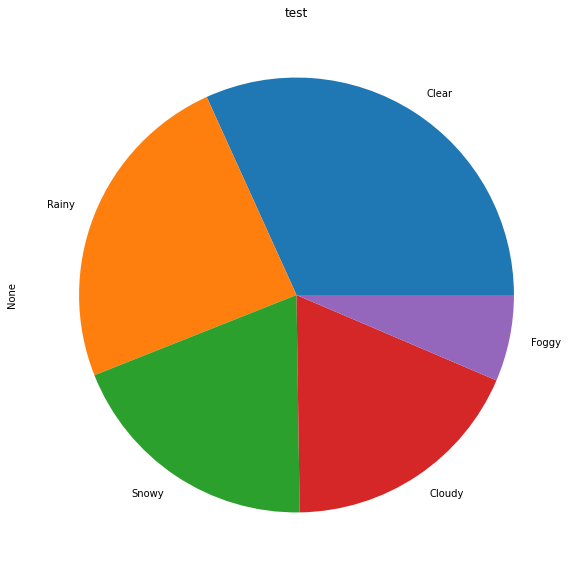

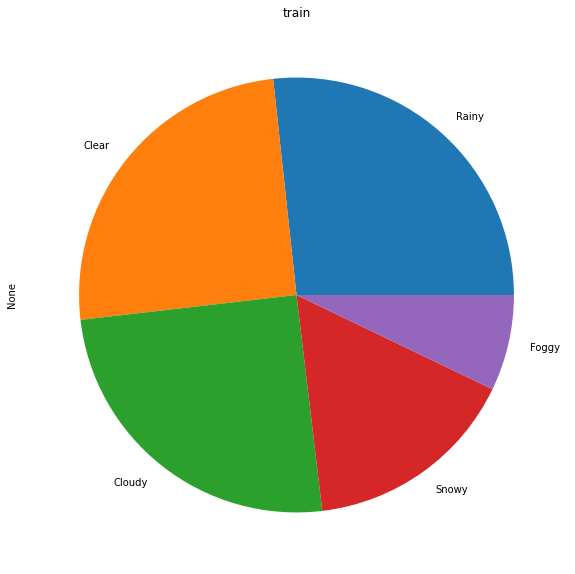

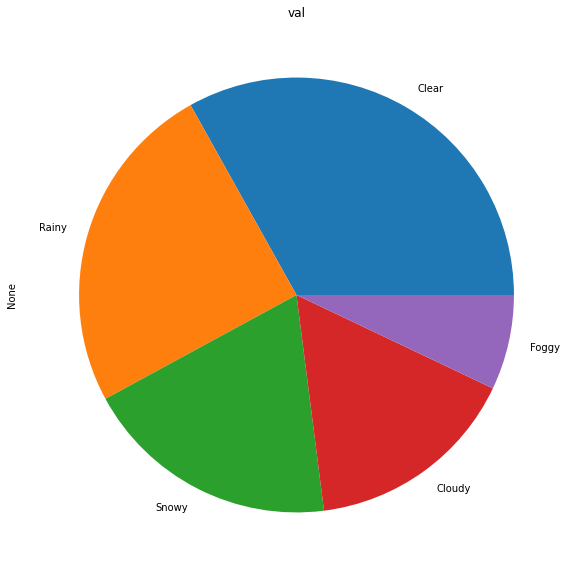

In [43]:
for t in df.ds_type.unique():
    plt.figure(figsize=(10,10))
    l = df.query('ds_type == @t')
    l.value_counts("weather").plot.pie()
    plt.title(t)
    plt.show()

In [44]:
df.value_counts(["ds_type"],normalize=True)

ds_type
train      0.834610
test       0.086247
val        0.079144
dtype: float64

In [45]:
import hashlib
import tqdm
import cv2
df["id"] = df.path.apply(lambda x:hashlib.sha224(str.encode(x)).hexdigest()+".jpg")

out = r"C:\Felix\weather_data_set_ready_to_train"
for t in df.ds_type.unique():
    for w in df.weather.unique():
        os.makedirs(os.path.join(out,t,w),exist_ok=True)
for i in tqdm.tqdm(range(len(df))):
    row= df.iloc[i]

    img = cv2.imread(row.path)
    if img.shape[0] > 400 or img.shape[1] > 400:
        img = cv2.resize(img, [400,400], interpolation= cv2.INTER_LINEAR)
    cv2.imwrite(os.path.join(out,row.ds_type,row.weather,row.id),img)

100%|██████████| 19850/19850 [06:39<00:00, 49.69it/s] 


In [46]:
df.reset_index().to_feather(os.path.join(out,"df.feather"))

In [47]:
df.path.duplicated().any()

False